In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os

In [3]:
cwd =  os.getcwd()
print('Current working directory:', cwd)

data_dir = os.path.join(cwd, 'data_2023')

# Check if the directory exists
if os.path.isdir(data_dir):
    print('Data directory found at', data_dir)
else:
    print('Error: data directory not found')

print(os.listdir(data_dir))

Current working directory: /Users/harrybingham/Documents/GitHub/anxiety-rl-analysis
Data directory found at /Users/harrybingham/Documents/GitHub/anxiety-rl-analysis/data_2023
['inst_outcomes.csv', 'stai_scores.csv', 'inst_choices.csv', 'README.md']


In [4]:
# Load the STAI-Y2 scores data
stai_df = pd.read_csv(os.path.join(data_dir, 'stai_scores.csv'))

# Load the choices data
choices_df = pd.read_csv(os.path.join(data_dir, 'inst_choices.csv'))

# Load the outcomes data
outcomes_df = pd.read_csv(os.path.join(data_dir, 'inst_outcomes.csv'))

""" All data has been loaded correctly. """

' All data has been loaded correctly. '

In [5]:
num_trials = 160

In [6]:
mean_stai = stai_df.mean()
print('Mean STAI score:', mean_stai)

median_stai = stai_df.median()
print('Median STAI score:', median_stai)

std_stai = stai_df.std()
print('Standard deviation of STAI score:', std_stai)

Mean STAI score: 65    42.265306
dtype: float64
Median STAI score: 65    39.0
dtype: float64
Standard deviation of STAI score: 65    14.6796
dtype: float64


In [7]:
stai_cutoff = 43
num_healthy_controls = (len(stai_df[stai_df.iloc[:, 0] <= stai_cutoff]) + 1)
num_participants = (stai_df.shape[0] + 1)
print("Number of participants", num_participants)
print('Number of healthy controls:', num_healthy_controls)
print('Number of anxious participants:', num_participants - num_healthy_controls)

""" The number of participants expected to fit in each group based on self-resport is 25/25 (control/anxious). However, given a STAI cutoff of 43, the number of participants in each group is 30/20 (controls/anxious). Hereafter, we will assume the self-reported data is correct. """

Number of participants 50
Number of healthy controls: 30
Number of anxious participants: 20


' The number of participants expected to fit in each group based on self-resport is 25/25 (control/anxious). However, given a STAI cutoff of 43, the number of participants in each group is 30/20 (controls/anxious). Hereafter, we will assume the self-reported data is correct. '

In [8]:
""" 
Compute the number of times each participant choose option A. Report the average of this number (or
percentage) across all subjects. What is the expected number of aversive sounds experienced by participants
who respond randomly throughout the experiment? Did our participants perform the task well? 
"""

# Compute the number of times each participant chose option A
num_A = []
for index, row in choices_df.iterrows():
    num_A.append(row.tolist().count(1))

print("Number of times each participant chose option A", num_A)

# Compute the average number of times each participant chose option A
avg_num_A = np.mean(num_A)
print('Average number of times each participant chose option A:', avg_num_A)

""" 
The expected number of aversive sounds experienced by participants given random choices is 80. The average number of times each participant chose option A is 34.1 . 
This suggests that our participants performed the task well. 21.3% of the time, they chose option A
"""
None

Number of times each participant chose option A [46, 32, 58, 37, 26, 28, 50, 38, 51, 53, 30, 31, 41, 36, 33, 41, 41, 28, 37, 53, 33, 40, 67, 31, 45, 29, 6, 25, 7, 12, 29, 21, 29, 16, 36, 39, 27, 41, 25, 39, 28, 29, 36, 45, 24, 16, 53, 31, 22]
Average number of times each participant chose option A: 34.10204081632653


In [9]:
def update_V(V_i_t, o_t, alpha):
    """
    Update the value of V_i at time t+1 given its previous value at time t and the observed outcome o_t.
    
    Args:
    V_i_t (float): The previous value of V_i at time t.
    o_t (float): The observed outcome at time t.
    alpha (float): The learning rate.
    
    Returns:
    float: The updated value of V_i at time t+1.
    """
    V_i_t_plus_1 = V_i_t + alpha * (o_t - V_i_t)
    return V_i_t_plus_1

def p(action, V_A, V_B, beta):
    # Compute the exponentiated values for each option
    exp_A = np.exp(-beta * V_A)
    exp_B = np.exp(-beta * V_B)

    # Compute the probability of selecting option A
    probability = exp_A / (exp_A + exp_B)

    # Return the probability of selecting the specified action
    if action == 'A':
        return probability
    else:
        return 1 - probability



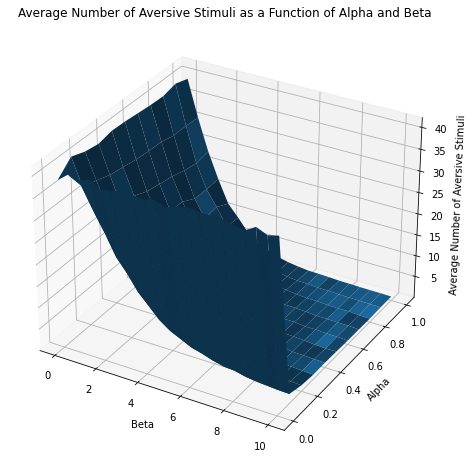

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def simulate_aversive_stimuli(alpha, beta, V0, num_trials, num_simulations):
    aversive_stimuli_count = 0

    for _ in range(num_simulations):
        V_A = V0
        V_B = V0

        for t in range(1, num_trials + 1):
            # Calculate the probability of choosing action A
            prob_A = p('A', V_A, V_B, beta)

            # Randomly choose action A or B based on the probabilities
            action = np.random.choice(['A', 'B'], p=[prob_A, 1 - prob_A])

            # Determine the outcome based on the current trial and chosen action
            o_t = 1 if (t - 1) % 40 < 20 and action == 'A' else 0

            # Update the values of V_A and V_B based on the chosen action and outcome
            if action == 'A':
                V_A = update_V(V_A, o_t, alpha)
            else:
                V_B = update_V(V_B, o_t, alpha)

            aversive_stimuli_count += o_t

    avg_aversive_stimuli = aversive_stimuli_count / num_simulations
    return avg_aversive_stimuli

# Parameter ranges
alpha_values = np.linspace(0, 1, 11)
beta_values = np.linspace(0, 10, 21)

# Simulations
V0 = 0.5
num_trials = 160
num_simulations = 100

# Compute the average number of aversive stimuli for each combination of alpha and beta
results = np.zeros((len(alpha_values), len(beta_values)))

for i, alpha in enumerate(alpha_values):
    for j, beta in enumerate(beta_values):
        results[i, j] = simulate_aversive_stimuli(alpha, beta, V0, num_trials, num_simulations)

# 3D plot of the results
X, Y = np.meshgrid(beta_values, alpha_values)
Z = results

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

ax.set_xlabel('Beta')
ax.set_ylabel('Alpha')
ax.set_zlabel('Average Number of Aversive Stimuli')
ax.set_title('Average Number of Aversive Stimuli as a Function of Alpha and Beta')

plt.show()

In [11]:
import numpy as np

def negative_log_likelihood(choices, outcomes, V0, alpha, beta):
    num_trials = len(choices)
    V_A = V0
    V_B = V0
    NLL = 0

    for t in range(num_trials):
        choice = choices[t]
        outcome = outcomes[t]

        # Calculate the probability of the chosen action given the current values of V_A and V_B
        if choice == 1:
            prob_choice = p('A', V_A, V_B, beta)
        else:
            prob_choice = p('B', V_A, V_B, beta)

        # Update the negative log likelihood
        NLL -= np.log(prob_choice)

        # Update the values of V_A and V_B based on the chosen action and observed outcome
        if choice == 1:
            V_A = update_V(V_A, outcome, alpha)
        else:
            V_B = update_V(V_B, outcome, alpha)

    return NLL

# Get the data for the 4th and 5th participant
choices_4th = choices_df.iloc[3].tolist()
outcomes_4th = outcomes_df.iloc[3].tolist()
choices_5th = choices_df.iloc[4].tolist()
outcomes_5th = outcomes_df.iloc[4].tolist()

# Set the parameter values
V0 = 0.5
alpha = 0.4
beta = 7

# Calculate the NLL for the 4th and 5th participant
NLL_4th = negative_log_likelihood(choices_4th, outcomes_4th, V0, alpha, beta)
NLL_5th = negative_log_likelihood(choices_5th, outcomes_5th, V0, alpha, beta)

print("NLL for the 4th participant:", NLL_4th)
print("NLL for the 5th participant:", NLL_5th)


NLL for the 4th participant: 52.68861467295331
NLL for the 5th participant: 49.57025421866699


Mean alpha: 0.466979155524904
Variance of alpha: 0.025444294810561832
Mean beta: 5.167725090907229
Variance of beta: 2.8207544234744524


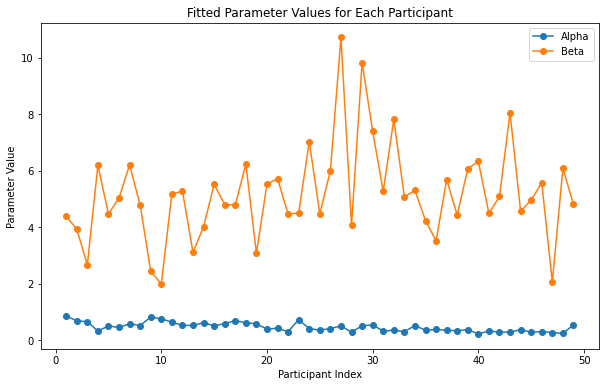

Correlation between alpha and beta (all participants): -0.2508587253510635
Correlation between alpha and beta (high anxious): -0.518660548011901
Correlation between alpha and beta (low anxious): 0.41203337181471433


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Assuming you have already loaded the choices and outcomes data into choices_df and outcomes_df

def minimize_nll_for_individual(choices, outcomes, V0, initial_params):
    res = minimize(lambda x: negative_log_likelihood(choices, outcomes, V0, x[0], x[1]),
                   initial_params, method='Nelder-Mead')
    return res.x

# Define the initial parameter values
initial_params = [0.4, 7]
V0 = 0.5

# Fit the parameters for each participant
num_participants = len(choices_df)
fitted_params = np.zeros((num_participants, 2))

for i in range(num_participants):
    choices = choices_df.iloc[i].tolist()
    outcomes = outcomes_df.iloc[i].tolist()
    fitted_params[i] = minimize_nll_for_individual(choices, outcomes, V0, initial_params)

# Calculate mean and variance of fitted parameter values
mean_alpha = np.mean(fitted_params[:, 0])
var_alpha = np.var(fitted_params[:, 0])
mean_beta = np.mean(fitted_params[:, 1])
var_beta = np.var(fitted_params[:, 1])

print("Mean alpha:", mean_alpha)
print("Variance of alpha:", var_alpha)
print("Mean beta:", mean_beta)
print("Variance of beta:", var_beta)

# Plot the parameter values against participant index
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_participants + 1), fitted_params[:, 0], label='Alpha', marker='o')
plt.plot(range(1, num_participants + 1), fitted_params[:, 1], label='Beta', marker='o')
plt.xlabel('Participant Index')
plt.ylabel('Parameter Value')
plt.title('Fitted Parameter Values for Each Participant')
plt.legend()
plt.show()

# Calculate Pearson's correlation coefficients
correlation_all = np.corrcoef(fitted_params[:, 0], fitted_params[:, 1])[0, 1]
correlation_high_anxious = np.corrcoef(fitted_params[:25, 0], fitted_params[:25, 1])[0, 1]
correlation_low_anxious = np.corrcoef(fitted_params[25:, 0], fitted_params[25:, 1])[0, 1]

print("Correlation between alpha and beta (all participants):", correlation_all)
print("Correlation between alpha and beta (high anxious):", correlation_high_anxious)
print("Correlation between alpha and beta (low anxious):", correlation_low_anxious)
